In [18]:
import os
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset


class PairedHDF5Dataset(Dataset):
    def __init__(self, data_dir, groundtruth_dir):
        super(PairedHDF5Dataset, self).__init__()

        # Get a list of paths
        self.data_paths = sorted(
            [os.path.join(data_dir, file) for file in os.listdir(data_dir) if file.endswith('.hdf5')])
        self.groundtruth_paths = sorted(
            [os.path.join(groundtruth_dir, file) for file in os.listdir(groundtruth_dir) if file.endswith('.hdf5')])

        assert len(self.data_paths) == len(self.groundtruth_paths), "Mismatch between data and groundtruth files"

        # Calculate the cumulative sizes
        self.cumulative_sizes = []
        cum_size = 0
        for path in self.data_paths:
            with h5py.File(path, 'r') as file:
                cum_size += len(file['data'])
                self.cumulative_sizes.append(cum_size)

    def __len__(self):
        return self.cumulative_sizes[-1]

    def __getitem__(self, index):
        # Find the correct file and local index
        file_idx = next(i for i, cum_size in enumerate(self.cumulative_sizes) if cum_size > index)
        if file_idx == 0:
            local_index = index
        else:
            local_index = index - self.cumulative_sizes[file_idx - 1]

        with h5py.File(self.data_paths[file_idx], 'r') as data_file, h5py.File(self.groundtruth_paths[file_idx],
                                                                               'r') as gt_file:
            data = torch.tensor(np.expand_dims(data_file['data'][local_index], axis=0).squeeze())
            groundtruth = torch.tensor(np.expand_dims(gt_file['data'][local_index], axis=0).squeeze())
        return data, groundtruth


# Usage:
train_dataset = PairedHDF5Dataset(
    'C:\\Users\sun\PycharmProjects\known_operator\LoDoPaB-CT\observation_train',
    'C:\\Users\sun\PycharmProjects\known_operator\LoDoPaB-CT\ground_truth_train'
)

validation_dataset = PairedHDF5Dataset(
    'C:\\Users\sun\PycharmProjects\known_operator\LoDoPaB-CT\observation_validation',
    'C:\\Users\sun\PycharmProjects\known_operator\LoDoPaB-CT\ground_truth_validation'
)

from torch.utils.data import Subset
import random

# Randomly sample 200 indices from the dataset
i = random.sample(range(len(train_dataset)), 100)
j = random.sample(range(len(validation_dataset)), 10)
# Create a subset from the train_dataset using the sampled indices
subset_dataset = Subset(train_dataset, i)
valsubset_dataset = Subset(train_dataset, j)

from torch.utils.data import DataLoader

data_loader = DataLoader(subset_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(valsubset_dataset, batch_size=1, shuffle=True)

In [19]:
from pyronn.ct_reconstruction.geometry.geometry import Geometry
from pyronn.ct_reconstruction.helpers.trajectories.circular_trajectory import circular_trajectory_2d

# Initializing CT geometry parameters:

# Volume parameters:
volume_size = 362  # size of the volume/image
volume_shape = [volume_size, volume_size]  # shape of the volume as [height, width]
volume_spacing = [1, 1]  # spacing between pixels in the volume

# Detector parameters:
detector_shape = [513]  # shape of the detector
detector_spacing = [1]  # spacing between detector pixels

# Trajectory parameters:
number_of_projections = 1000  # number of projections in the sinogram
angular_range = -np.pi  # angular range of the trajectory (half-circle in this case)

# Create an instance of the Geometry class and initialize it with the above parameters
geometry = Geometry()
geometry.init_from_parameters(volume_shape=volume_shape, volume_spacing=volume_spacing,
                              detector_shape=detector_shape, detector_spacing=detector_spacing,
                              number_of_projections=number_of_projections, angular_range=angular_range,
                              trajectory=circular_trajectory_2d)

from torch import nn
from pyronn.ct_reconstruction.layers.reconstruction import ParallelBeamReconstruction2D
from traiable_filter import ParReconstruction2D
from pyronn.ct_reconstruction.helpers.filters import filters

model = ParReconstruction2D(geometry).cuda()

Epoch [1/20], Train Loss: 0.0099, Val Loss: 0.0085
Epoch [2/20], Train Loss: 0.0079, Val Loss: 0.0066
Epoch [3/20], Train Loss: 0.0054, Val Loss: 0.0041
Epoch [4/20], Train Loss: 0.0031, Val Loss: 0.0023
Epoch [5/20], Train Loss: 0.0019, Val Loss: 0.0015
Epoch [6/20], Train Loss: 0.0013, Val Loss: 0.0011
Epoch [7/20], Train Loss: 0.0010, Val Loss: 0.0008
Epoch [8/20], Train Loss: 0.0008, Val Loss: 0.0007
Epoch [9/20], Train Loss: 0.0007, Val Loss: 0.0006
Epoch [10/20], Train Loss: 0.0006, Val Loss: 0.0006
Epoch [11/20], Train Loss: 0.0006, Val Loss: 0.0005
Epoch [12/20], Train Loss: 0.0005, Val Loss: 0.0005
Epoch [13/20], Train Loss: 0.0005, Val Loss: 0.0005
Epoch [14/20], Train Loss: 0.0005, Val Loss: 0.0004
Epoch [15/20], Train Loss: 0.0005, Val Loss: 0.0004
Epoch [16/20], Train Loss: 0.0005, Val Loss: 0.0004
Epoch [17/20], Train Loss: 0.0005, Val Loss: 0.0004
Epoch [18/20], Train Loss: 0.0005, Val Loss: 0.0004
Epoch [19/20], Train Loss: 0.0005, Val Loss: 0.0004
Epoch [20/20], Train 

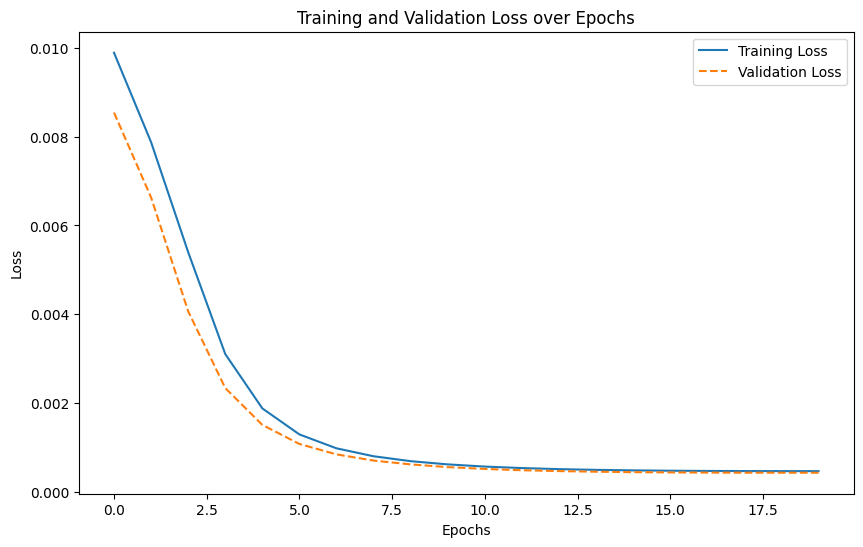

In [20]:
import matplotlib.pyplot as plt

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(data_loader), epochs=20)
num_epochs = 20


def train_model(model, data_loader, optimizer, num_epochs, val_loader=None, save_path="best_model.pth"):
    train_loss_history = []
    val_loss_history = []

    best_val_loss = float('inf')  # Initialize with a high value

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_batches = len(data_loader)

        for batch_idx, (data, groundtruth) in enumerate(data_loader):
            data, groundtruth = data.cuda(), groundtruth.cuda()

            optimizer.zero_grad()
            outputs = model(data)
            loss = nn.MSELoss()(outputs, groundtruth)
            loss.backward(retain_graph=True)
            optimizer.step()
            running_loss += loss.item()
            scheduler.step()

        avg_train_loss = running_loss / total_batches
        train_loss_history.append(avg_train_loss)

        # Validation phase
        if val_loader:
            model.eval()
            val_running_loss = 0.0
            with torch.no_grad():
                for data, groundtruth in val_loader:
                    data, groundtruth = data.cuda(), groundtruth.cuda()
                    outputs = model(data)
                    loss = nn.MSELoss()(outputs, groundtruth)
                    val_running_loss += loss.item()

            avg_val_loss = val_running_loss / len(val_loader)

            # Check if this is the best model
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(model.state_dict(), save_path)  # Save the best model

            val_loss_history.append(avg_val_loss)
            print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        else:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

    print("Finished Training")
    return train_loss_history, val_loss_history


loss_history, val_loss_history = train_model(model, data_loader, optimizer, num_epochs, val_loader)
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

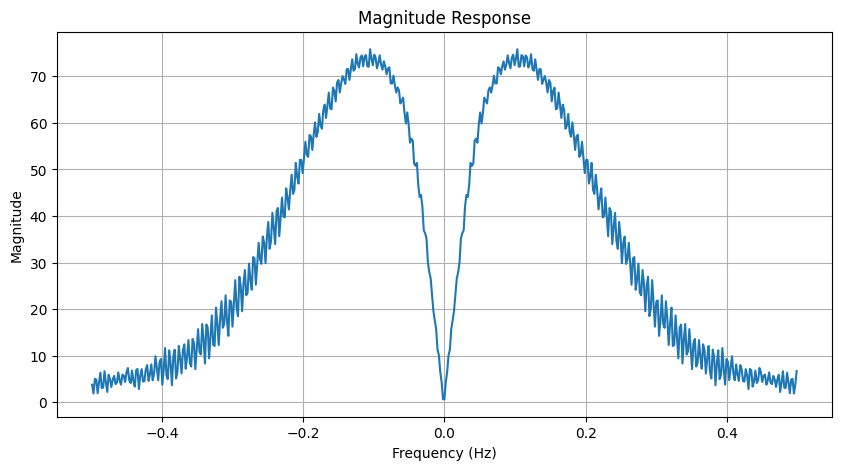

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming this is the frequency domain representation of your filter
filter_freq_domain = model.filter.filter_1d.detach().cpu().numpy().squeeze()

# Get the frequencies for positive and negative values
frequencies = np.fft.fftshift(np.fft.fftfreq(len(filter_freq_domain)))

# Shift the zero-frequency component to the center
filter_freq_domain_centered = np.fft.fftshift(filter_freq_domain)

# Now plot the magnitude response
plt.figure(figsize=(10, 5))
plt.plot(frequencies, filter_freq_domain_centered)
plt.title('Magnitude Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

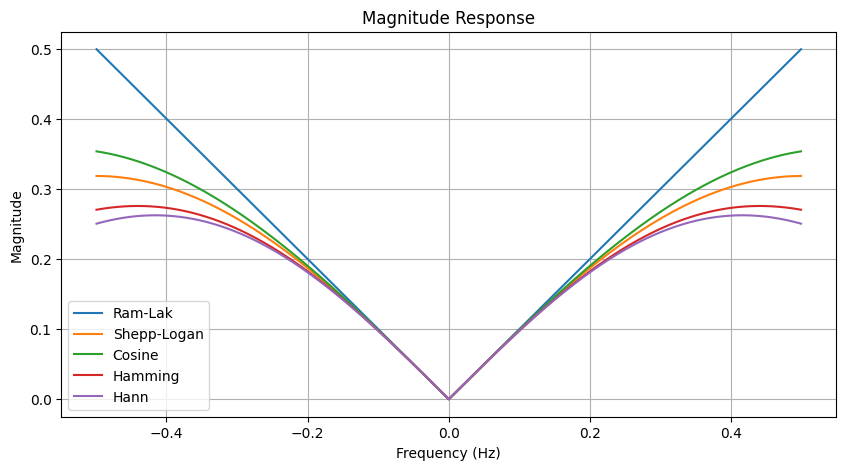

In [34]:
from pyronn.ct_reconstruction.helpers.filters.filters import ram_lak, shepp_logan, cosine, hamming, hann


def plot_filters(num_detectors):
    # Generate filters
    ram_lak1 = ram_lak(num_detectors, 1)
    shepp_logan1 = shepp_logan(num_detectors, 1)
    cosine1 = cosine(num_detectors, 1)
    hamming1 = hamming(num_detectors, 1)
    hann1 = hann(num_detectors, 1)

    # Get the frequencies for positive and negative values
    frequencies = np.fft.fftshift(np.fft.fftfreq(num_detectors))

    # Now plot the magnitude response
    plt.figure(figsize=(10, 5))
    plt.plot(frequencies, np.fft.fftshift(ram_lak1), label='Ram-Lak')
    plt.plot(frequencies, np.fft.fftshift(shepp_logan1), label='Shepp-Logan')
    plt.plot(frequencies, np.fft.fftshift(cosine1), label='Cosine')
    plt.plot(frequencies, np.fft.fftshift(hamming1), label='Hamming')
    plt.plot(frequencies, np.fft.fftshift(hann1), label='Hann')

    plt.title('Magnitude Response')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.legend()  # Add legend to differentiate filters
    plt.grid(True)
    plt.show()


# Call the function with the desired number of detectors
plot_filters(513)

In [23]:
def load_data_from_hdf5(filename, dataset_name="data"):
    with h5py.File(filename, 'r') as f:
        # Assuming the dataset is 3D and you want the first image
        data = f[dataset_name][-1, :, :]
    return data


phantom = load_data_from_hdf5("../LoDoPaB-CT/ground_truth_test/ground_truth_test_000.hdf5")
phantom = torch.tensor(np.expand_dims(phantom, axis=0).copy(), dtype=torch.float32).cuda()
sinogram = load_data_from_hdf5("../LoDoPaB-CT/observation_test/observation_test_000.hdf5")
sinogram = torch.tensor(np.expand_dims(sinogram, axis=0).copy(), dtype=torch.float32).cuda()

In [24]:
if os.path.exists("best_model.pth"):
    model.load_state_dict(torch.load("best_model.pth"))


In [25]:
model.eval()
reconstruction = model(sinogram)

In [26]:
reco_filter = filters.hann_2D(geometry.detector_shape,
                              geometry.detector_spacing,
                              geometry.number_of_projections)

FBP = ParallelBeamReconstruction2D(geometry=geometry, filter=reco_filter, tainable_filter=False).cuda()
FBP.eval()
reconstruction_FBP = FBP(sinogram, **geometry)

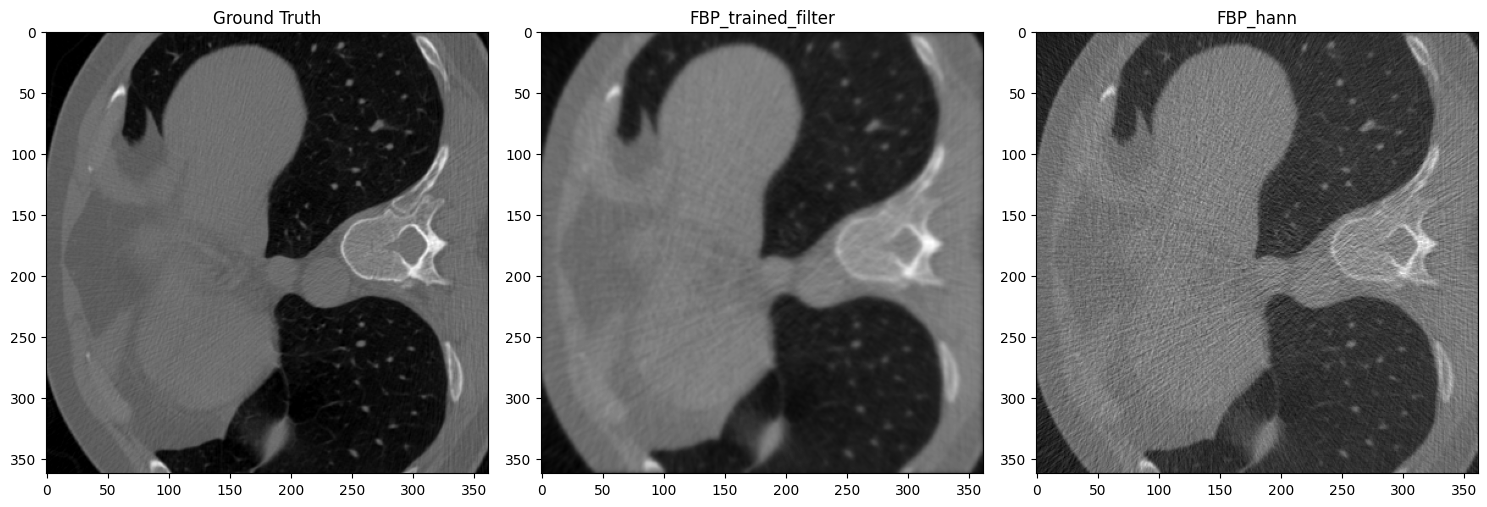

In [27]:
def normalize_image(image: np.ndarray) -> np.ndarray:
    """Normalize the pixel values of an image to the range [0, 1]."""
    min_val = image.min()
    max_val = image.max()

    return (image - min_val) / (max_val - min_val)


plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(normalize_image(phantom.squeeze().cpu()), cmap='gray')
plt.title('Ground Truth')

plt.subplot(1, 3, 2)
plt.imshow(normalize_image(reconstruction.detach().cpu().numpy().squeeze()), cmap='gray')
plt.title('FBP_trained_filter')

plt.subplot(1, 3, 3)
plt.imshow(normalize_image(reconstruction_FBP.cpu().detach().numpy().squeeze()), cmap='gray')
plt.title('FBP_hann')

plt.tight_layout()
plt.show()

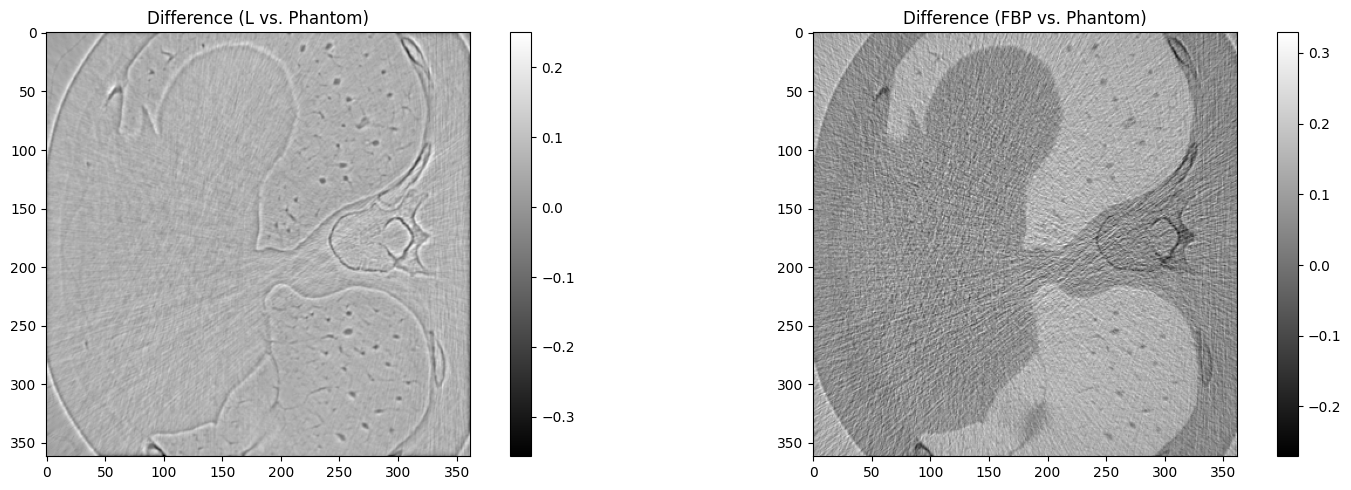

Mean Squared Error (MSE) between L and Phantom: 0.0003
Mean Squared Error (MSE) between FBP and Phantom: 0.0412


In [28]:
difference_learn = normalize_image(reconstruction.squeeze().cpu().detach().numpy()) - normalize_image(
    phantom.squeeze().cpu().numpy())
difference_fbp = normalize_image(reconstruction_FBP.squeeze().cpu().detach().numpy()) - normalize_image(
    phantom.squeeze().cpu().numpy())

plt.figure(figsize=(16, 5))

# Display the difference image between IR and phantom.
plt.subplot(1, 2, 1)
plt.imshow(difference_learn, cmap='gray')
plt.title('Difference (L vs. Phantom)')
plt.colorbar()

# Display the difference image between FBP and phantom.
plt.subplot(1, 2, 2)
plt.imshow(difference_fbp, cmap='gray')
plt.title('Difference (FBP vs. Phantom)')
plt.colorbar()

plt.tight_layout()
plt.show()

# Calculate the MSE for each reconstruction method.
mse_ir = nn.MSELoss()(reconstruction, phantom).item()
mse_fbp = nn.MSELoss()(reconstruction_FBP, phantom).item()

print(f"Mean Squared Error (MSE) between L and Phantom: {mse_ir:.4f}")
print(f"Mean Squared Error (MSE) between FBP and Phantom: {mse_fbp:.4f}")